<a href="https://colab.research.google.com/github/rihat99/openai_gym/blob/main/cartpole_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras

env = gym.make('CartPole-v1')
tf.random.set_seed(42)
np.random.seed(42)
print(tf.__version__)
print(gym.__version__)

2.4.1
0.17.3


In [27]:
input_shape = [4]
n_outputs = 2

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [21]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

from collections import deque
replay_memory = deque(maxlen=10000)

def sample_experiences(batch_size):
    sample_size = min(batch_size, len(replay_memory))
    indices = np.random.randint(len(replay_memory), size=sample_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [22]:
batch_size = 32
discount_rate = 0.97
optimizer = keras.optimizers.Adam(lr=0.001)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)

    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [26]:
from IPython.display import clear_output
all_rewards = []
best_score = 0
epsilon = 1.0
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
for episode in range(150):
    obs = env.reset()
    current_reward = 0
    for step in range(200):
        #epsilon = max(1 - episode / 600, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        current_reward += reward
        training_step(batch_size)
        if step >= best_score:
            best_weights = model.get_weights()
            best_score = step
        if done:
            epsilon = max(0.1, epsilon*0.99)
            break

    target.set_weights(model.get_weights())
    all_rewards.append(current_reward)
    clear_output(wait=True)
    print('Episode:', episode, 'Current Reward:', current_reward)

model.set_weights(best_weights)

Episode: 149 Current Reward: 200.0


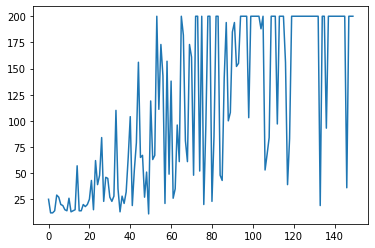

199


In [29]:
import matplotlib.pyplot as plt

plt.plot(all_rewards)
plt.show()
print(best_score)

In [30]:
model.save('CartpoleQ')

INFO:tensorflow:Assets written to: CartpoleQ/assets


In [31]:
reconstructed_model = keras.models.load_model('CartpoleQ')

def smart_policy(obs):
    Q_values = model(obs[np.newaxis])
    return np.argmax(Q_values[0])

totals = []
for episode in range(100):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
        action = smart_policy(obs)
        obs, reward, done, info = env.step(action)
        #env.render()
        episode_reward += reward
        if done:
            break
    totals.append(episode_reward)

env.close()

import numpy as np
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
#print(totals)

200.0 0.0 200.0 200.0
